In [1]:
import numpy as np
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets

import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# adata = anndata.read_h5ad("../data/cellcycle_maxine/RPE_37C_Rep1_full.h5ad")
DATA_FOLDER = "../../../../data/"
adata = anndata.read_h5ad(f"{DATA_FOLDER}cellcycle_maxine/VASA_preprocesseed.h5ad")
adata

AnnData object with n_obs × n_vars = 38913 × 16011
    obs: 'Cell_ID', 'obs_names', 'Stage', 'Dataset', 'G0?', 'UMAP_phase', 'UMI_SUM', 'S-phase', 'Celltype', 's_counts', 'u_counts', 'percent_unspliced', 'total_counts', 'pca_theta'
    var: 'var_names', 'Type', 'n_cells'
    uns: 'log1p'
    layers: 'matrix', 's_log', 's_norm', 'spliced', 'u_log', 'u_norm', 'unspliced'

In [4]:
adata.obs["Celltype"] = adata.obs["Celltype"].cat.add_categories("Unknown")
adata.obs["Celltype"].fillna("Unknown", inplace=True)

/tmp/ipykernel_98825/1836273176.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  adata.obs["Celltype"].fillna("Unknown", inplace=True)


In [5]:
# Preprocess data
adata.X = adata.layers["spliced"]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata_all_genes = adata.copy()
layer_to_use = "spliced"
library_size = adata_all_genes.layers[layer_to_use].sum(axis=1).A1
SMALL_CYCLING_GENE_SET = gene_sets.SMALL_CELL_CYCLE_GENE_SET
adata = adata[:, adata.var_names.isin(SMALL_CYCLING_GENE_SET)]

In [6]:
adata.X = adata.X - adata.X.mean(axis=1)

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)
/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/anndata/_core/anndata.py:617: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)
/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [7]:
# pca on the data
sc.pp.pca(adata)

/home/maxine/miniconda3/envs/VAE_Fourrier_Env/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:314: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm[key_obsm] = X_pca


In [8]:
import pickle

vasa_results = pickle.load(open("../data/vasa_res.pkl", "rb"))

<Axes: >

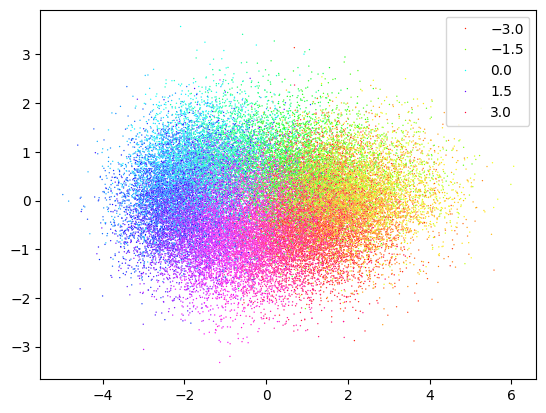

In [9]:
sns.scatterplot(
    x=adata.obsm["X_pca"][:, 0],
    y=adata.obsm["X_pca"][:, 2],
    hue=vasa_results["phases"].values,
    palette="hsv",
    s=1,
)

In [10]:
pca_phase = np.arctan2(adata.obsm["X_pca"][:, 0], adata.obsm["X_pca"][:, 2])

In [11]:
adata.obs

,Cell_ID,obs_names,Stage,Dataset,G0?,UMAP_phase,UMI_SUM,S-phase,Celltype,s_counts,u_counts,percent_unspliced,total_counts,pca_theta
0,AAACAAACAAAGCCTA_E8.5-19_i36,0,E8.5,E8.5-19_i36,0.0,2.234725,3716.0,NaN,Unknown,3714,4097,0.524517,3714,3.116877
1,AAACAAACAAAGCCTA_E8.5-7_i20,1,E8.5,E8.5-7_i20,0.0,4.659329,6066.0,NaN,Unknown,6066,5598,0.479938,6066,0.584829
2,AAACAAACAACAATCC_E9.5-6_i42,2,E9.5,E9.5-6_i42,0.0,1.721789,6203.0,1.0,Intermediate Mesoderm I,6203,5817,0.483943,6203,-1.683279
3,AAACAAACAACCCTTG_E8.5-2_i16,3,E8.5,E8.5-2_i16,0.0,5.050425,26326.0,NaN,Unknown,26326,22491,0.460721,26326,-0.140485
4,AAACAAACAACCCTTG_E9.5-4_i27,4,E9.5,E9.5-4_i27,0.0,2.447364,7234.0,1.0,Paraxial Mesoderm,7233,10065,0.581859,7233,3.073479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46117,TGTTATCATTAGGACC_E9.5-5_i28,46117,E9.5,E9.5-5_i28,0.0,6.099113,12009.0,0.0,Intermediate Mesoderm I,12008,12064,0.501163,12008,0.965278
46118,TGTTATCATTCCAGAC_E9.5-5_i28,46118,E9.5,E9.5-5_i28,0.0,1.952546,8341.0,1.0,Paraxial Mesoderm,8341,8797,0.513304,8341,3.028000
46120,TGTTATCATTGATCTA_E8.5-2_i16,46120,E8.5,E8.5-2_i16,0.0,6.067719,3548.0,0.0,Somites,3548,5096,0.589542,3548,0.331325
46121,TGTTATCATTGCATAT_E9.5-8_i44,46121,E9.5,E9.5-8_i44,0.0,1.767173,4804.0,NaN,Unknown,4804,5316,0.525296,4804,2.944686


<Axes: ylabel='Density'>

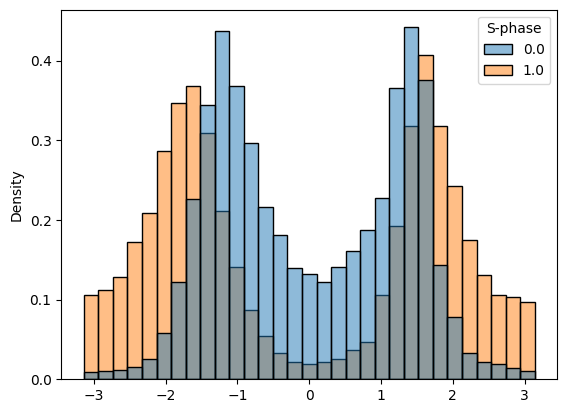

In [12]:
sns.histplot(
    x=pca_phase,
    hue=adata.obs["S-phase"],
    stat="density",
    common_norm=False,
)

In [13]:
adata.obs["pca_phase"] = pca_phase

In [14]:
utils.get_jensenshannon(adata, "pca_phase", "S-phase")

0.44477519129420096

In [15]:
vasa_results["JS_res"]["PCA"] = [utils.get_jensenshannon(adata, "pca_phase", "S-phase")]

In [16]:
with open("../data/vasa_res.pkl", "wb") as f:
    pickle.dump(vasa_results, f)